# Group 1 Capstone Project Work
### Make sure to make / checkout your own branch before making changes

# Maddie Hince

In [318]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
                              
movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter= '\t')
                            
reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding = 'latin')

movies_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
                            
movie_budgets_df = pd.read_csv("zippedData/tn.movie_budgets.csv.gz",index_col=0)

conn = sqlite3.connect('zippedData/im.db')



# Cat Murad

# Elijah Soba

# Luis Estrada 

# Kilmar Lazo 

# Michael Eugene

In [56]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
                              
movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter= '\t')
                            
reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding = 'latin')

movies_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
                            
movie_budgets_df = pd.read_csv("zippedData/tn.movie_budgets.csv.gz",index_col=0)

conn = sqlite3.connect('zippedData/im.db')

In [57]:
df = movie_budgets_df

In [58]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 271.0+ KB


 Data Cleaning

In [59]:
df = df.apply(lambda x: x.str.replace(',',''))
df['domestic_gross'] = df['domestic_gross'].fillna(0.0).str.replace('[$,]', '').astype('float')

In [60]:
df['domestic_gross'] = df['domestic_gross'].replace(',', '')
df['domestic_gross'] = df['domestic_gross'].replace('$', '')


In [61]:
df['production_budget'] = df['production_budget'].str.replace(',', '')
df['production_budget'] = df['production_budget'].str.replace('$', '')


In [62]:
df = df.apply(lambda x: x.replace('$',''))
df['production_budget'] = df['production_budget'].fillna(0.0).replace('[$,]', '').astype('float')

In [80]:
df['worldwide_gross'] = df['worldwide_gross'].str.replace(',', '')
df['worldwide_gross'] = df['worldwide_gross'].str.replace('$', '')


In [81]:
sorted_df=df.sort_values(by ='production_budget', ascending = False)
sorted_df.head(15)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,2009,Avatar,425000000.0,760507625.0,2776345279
2,2011,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1045663875
3,2019,Dark Phoenix,350000000.0,42762350.0,149762350
4,2015,Avengers: Age of Ultron,330600000.0,459005868.0,1403013963
5,2017,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1316721747
6,2015,Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2053311220
7,2018,Avengers: Infinity War,300000000.0,678815482.0,2048134200
8,2007,Pirates of the Caribbean: At Worldâs End,300000000.0,309420425.0,963420425
9,2017,Justice League,300000000.0,229024295.0,655945209


In [14]:
my_fn =lambda x:float(x.replace(',',''))

In [16]:
df["domestic_gross"] =df["domestic_gross"].map(my_fn) 

In [65]:
sorted_df=df.sort_values(by ='domestic_gross', ascending = False)
sorted_df.head(15)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
6,Dec 18 2015,Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2053311220
1,Dec 18 2009,Avatar,425000000.0,760507625.0,2776345279
42,Feb 16 2018,Black Panther,200000000.0,700059566.0,1348258224
7,Apr 27 2018,Avengers: Infinity War,300000000.0,678815482.0,2048134200
43,Dec 19 1997,Titanic,200000000.0,659363944.0,2208208395
34,Jun 12 2015,Jurassic World,215000000.0,652270625.0,1648854864
27,May 4 2012,The Avengers,225000000.0,623279547.0,1517935897
5,Dec 15 2017,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1316721747
44,Jun 15 2018,Incredibles 2,200000000.0,608581744.0,1242520711


In [66]:
sorted_df=df.sort_values(by ='production_budget', ascending = False)
sorted_df.head(15)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,Dec 18 2009,Avatar,425000000.0,760507625.0,2776345279
2,May 20 2011,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1045663875
3,Jun 7 2019,Dark Phoenix,350000000.0,42762350.0,149762350
4,May 1 2015,Avengers: Age of Ultron,330600000.0,459005868.0,1403013963
5,Dec 15 2017,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1316721747
6,Dec 18 2015,Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2053311220
7,Apr 27 2018,Avengers: Infinity War,300000000.0,678815482.0,2048134200
8,May 24 2007,Pirates of the Caribbean: At Worldâs End,300000000.0,309420425.0,963420425
9,Nov 17 2017,Justice League,300000000.0,229024295.0,655945209


In [67]:
sorted_df=df.sort_values(by ='worldwide_gross', ascending = False)
sorted_df.head(15)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
63,Apr 1 2011,Insidious,1500000.0,54009150.0,99870886
48,Oct 27 2017,Thank You for Your Service,20000000.0,9479390.0,9985316
84,Apr 2 2004,Hellboy,60000000.0,59623958.0,99823958
98,Aug 8 2001,The Deep End,3000000.0,8823109.0,9981635
38,Aug 21 2009,Fifty Dead Men Walking,10000000.0,0.0,997921
14,Mar 21 1980,Mad Max,200000.0,8750000.0,99750000
62,Dec 31 2016,Airlift (2016),4400000.0,0.0,9969237
79,Aug 17 2018,Alpha,51000000.0,35851379.0,99624873
33,Sep 30 2005,Duma,12000000.0,870067.0,994790


In [78]:
sorted_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
63,Apr 1 2011,Insidious,1500000.0,54009150.0,99870886
48,Oct 27 2017,Thank You for Your Service,20000000.0,9479390.0,9985316
84,Apr 2 2004,Hellboy,60000000.0,59623958.0,99823958
98,Aug 8 2001,The Deep End,3000000.0,8823109.0,9981635
38,Aug 21 2009,Fifty Dead Men Walking,10000000.0,0.0,997921


In [70]:
my_fn =lambda x:float(x)


In [72]:
df['release_date'] = pd.to_datetime(df['release_date']).dt.year
df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,2009,Avatar,425000000.0,760507625.0,2776345279
2,2011,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1045663875
3,2019,Dark Phoenix,350000000.0,42762350.0,149762350
4,2015,Avengers: Age of Ultron,330600000.0,459005868.0,1403013963
5,2017,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1316721747


In [51]:
sorted_df=df.sort_values(by ='release_date', ascending = False)
sorted_df.head(15)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
95,2020,Moonfall,150000000.0,0.0,0
36,2020,Call of the Wild,82000000.0,0.0,0
6,2020,Hannibal the Conqueror,50000000.0,0.0,0
30,2019,Unhinged,29000000.0,0.0,0
71,2019,PLAYMOBIL,75000000.0,0.0,0
96,2019,Captain Marvel,175000000.0,426525952.0,1123061550
75,2019,Long Shot,40000000.0,30202860.0,43711031
33,2019,Unplanned,6000000.0,18107621.0,18107621
35,2019,Late Night,4000000.0,246305.0,246305


In [73]:
df.dtypes

release_date           int64
movie                 object
production_budget    float64
domestic_gross       float64
worldwide_gross       object
dtype: object

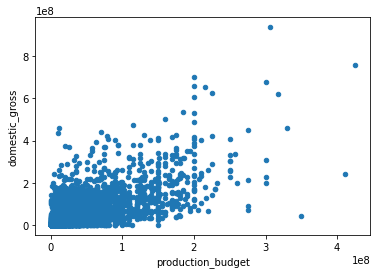

In [74]:

df.plot.scatter(x = 'production_budget', y = 'domestic_gross', s = 20);


<AxesSubplot:xlabel='production_budget', ylabel='domestic_gross'>

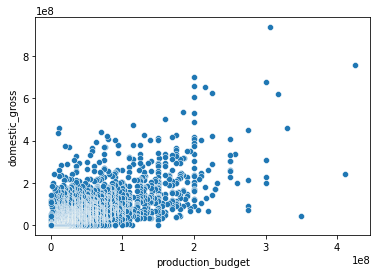

In [79]:
sns.scatterplot(x='production_budget', y='domestic_gross', data=df)


Top 30 years that producted the most movies.

<AxesSubplot:>

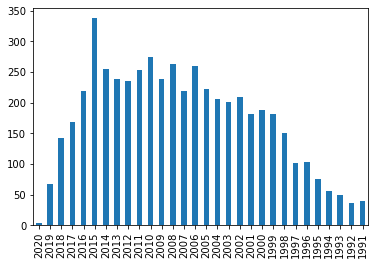

In [84]:
sorted_df['release_date'].value_counts().sort_index(ascending=False)[:30].plot.bar()

Looking at how  movies came out yearly since 2000

In [87]:
sorted_df = sorted_df[sorted_df['release_date'] > 2000]

In [88]:
sorted_df['release_date'].value_counts()

2015    338
2010    274
2008    264
2006    260
2014    255
2011    254
2009    239
2013    238
2012    235
2005    223
2007    220
2016    219
2002    210
2004    206
2003    201
2001    181
2017    168
2018    143
2019     67
2020      3
Name: release_date, dtype: int64